In [146]:
import numpy as np
from scipy import constants
import tabulate
import pandas as pd
import matplotlib.pyplot as plt
from IonChainTools import calcPositions,lengthScale,ion_position_potential
from tweezer_functions import *
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
#Constants in SI units
eps0 = constants.epsilon_0 
m = 39.9626*constants.atomic_mass
c = constants.c
e = constants.e
hbar = constants.hbar
pi = np.pi

# setting up parameters that we're not changing
NA = 0.1
tweezer_wavelength = 532e-9
omega_tweezer = 2*pi*c/tweezer_wavelength
df = pd.read_csv("S_P_only.csv",sep = ",",encoding = "UTF-8")
lambdares = np.array(df["wavelength (nm)"])*1e-9
omega_res = 2*pi*c/lambdares
linewidths = np.array(df["A_ki (s^-1)"])
lifetimes = linewidths

In [131]:
N = 2
#x = np.empty(N)
omega_rf_axial = 1 * 2 * pi * 1e6
P0 = 5e-3
beam_waist = 5e-6
omega_tw_radial = tweezer_optical_potential_to_trap_frequency(tweezer_wavelength,linewidths,omega_res,P0,beam_waist,m)[0]
#print(omega_tw_radial)
tweezed_ion = 0
displacement = beam_waist * 0.9
ionspacing = ion_spacing(N,omega_rf_axial)





In [132]:
tweeze_on = fsolve(pot_derivative_with_tweeze,ionspacing[0],args = (omega_rf_axial,omega_tw_radial,tweezed_ion,displacement))
print(tweeze_on)
print(ionspacing)
ionspacing[0] == fsolve(pot_derivative_with_tweeze,ionspacing[0],args = (omega_rf_axial,omega_tw_radial,tweezed_ion,displacement))

[-3.90936809e-06  2.80272106e-06]
[array([-2.80272106e-06,  2.80272106e-06]), [5.605442125952492e-06]]


array([False,  True])

In [133]:
tweeze_on[0] - ionspacing[0][tweezed_ion]

-1.106647030145291e-06

In [134]:
P0 = 5e-3
FWHM = (1)*1e-6
z_pos = 0
lambda_beam = 532e-9

#making a list of r-positions to pass through the potential function.  This is in the frame of the laser beam,
#so 0 is the center of the beam
r_pos = np.arange((1/2)*0.85*1e-6,(1/2)*(0.95)*1e-6,0.001e-6)

intens = intensity(P0,FWHM,z_pos,r_pos,lambda_beam)
a =  potential_position_dependent(omega_res,linewidths,omega_tweezer,intens)                      

[-3.13053288e-27  4.45579573e-15] [[ 2.28394984e-60 -1.12459535e-47]
 [-1.12459535e-47  5.56018832e-35]]


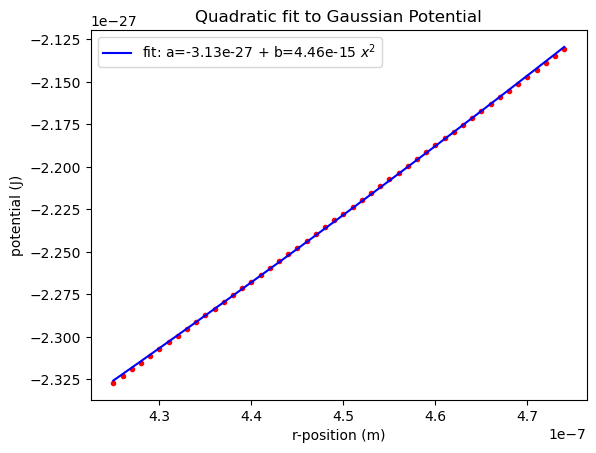

In [ ]:
#fitting the potential vector to a quadratic function
from scipy import optimize

def quadratic(x,a,b):
    return a+b*(x**2)
xdata = r_pos
ydata = a

popt, pcov = curve_fit(quadratic, xdata, ydata)

print(popt,pcov)

plt.plot(xdata,ydata,'r.')
plt.plot(xdata,quadratic(xdata, *popt) ,'b-',label=f'fit: a={popt[0]:.2e} + b={popt[1]:.2e} $x^{{2}}$')
plt.xlabel("r-position (m)")
plt.ylabel("potential (J)")
plt.title("Quadratic fit to Gaussian Potential")
plt.legend()
plt.show()

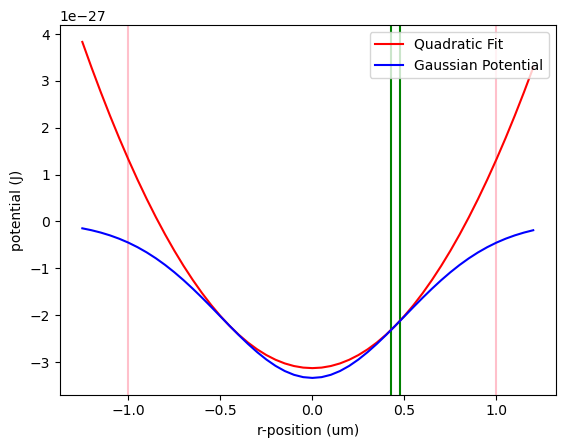

In [136]:

FWHM = 1e-6
r_pos = np.arange((-1.25)*1e-6,(1.25)*1e-6,0.05e-6)

intens = intensity(P0,FWHM,z_pos,r_pos,lambda_beam)
a =  potential_position_dependent(omega_res,linewidths,omega_tweezer,intens)  
plt.axvline(x=(FWHM/2)*0.85*1e6, color='g', linestyle='-')   
plt.axvline(x=(FWHM/2)*(0.95)*1e6, color='g', linestyle='-') 
plt.axvline(x = FWHM*1e6,color = 'pink')
plt.axvline(x = -FWHM*1e6,color = 'pink') 
plt.xlabel("r-position (um)")
plt.ylabel("potential (J)") 
plt.plot(r_pos*1e6,quadratic(r_pos, *popt) ,'r-',label="Quadratic Fit")
plt.plot(r_pos*1e6,a,'b-',label = "Gaussian Potential")
plt.legend(loc = 'upper right')
plt.savefig("Gaussian_Potential_Quad_Fit.png")
plt.show()

In [137]:
#popt[1] should be 1/2*k, so omega = sqrt(k/m)
fit = np.sqrt(2*popt[1]/m)
print(fit)
#I thought the fit from above should match the frequency found from below, since it's using the same beam params
P0 = 5e-3
test = tweezer_optical_potential_to_trap_frequency(lambda_beam,linewidths,omega_res,P0,FWHM,m)
print(test[0])
print(fit/test[0])

366459.6964641912
448673.5951480707
0.8167623422172918


In [138]:
#calculating the r-squared value of the fit
alpha_x = tuple(popt)[1]
residuals = ydata-  quadratic(xdata, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

0.9998655930166033


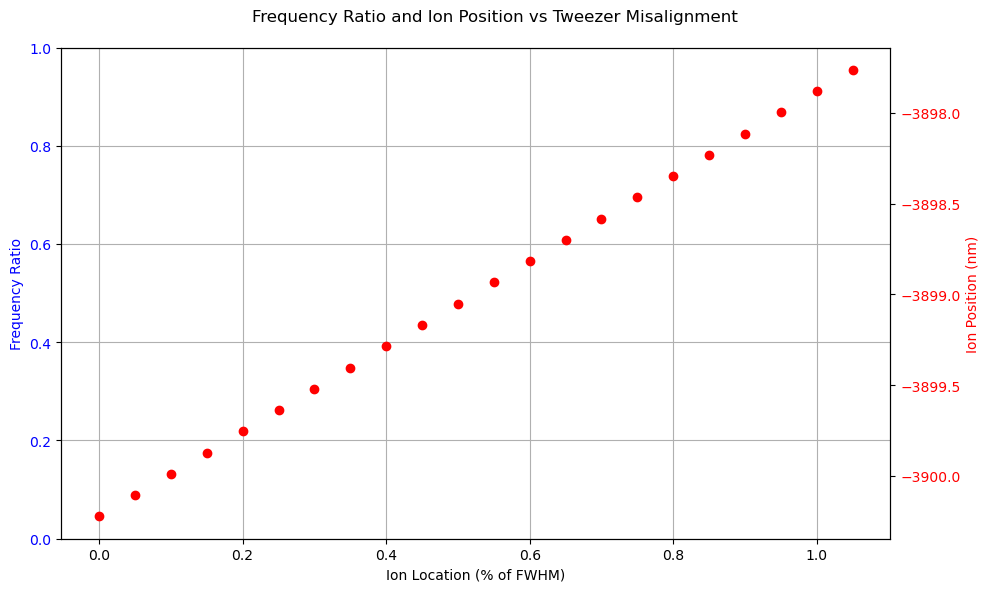

In [ ]:
dial_values = np.arange(0, 1.1, 0.05)  
results = []
ratios = []
errors = []  # To store the errors for the ratio
P0 = 5e-3
FWHM = 1e-6
z_pos = 0
lambda_beam = 532e-9
positions = []

num_points = 1000  # Define the number of points for `r_pos`
for dial in dial_values:
    # Calculate r_pos for each dial value
    if dial==0:
        r_max = 0.001e-5
        r_min = -0.001e-5
    else:
        r_max = (FWHM / 2) * (dial + dial * 0.025) 
        r_min = (FWHM / 2) * (dial - dial * 0.025)  
    r_pos = np.linspace(r_min, r_max, num_points)

    # Calculate ydata based on r_pos
    ydata = potential_position_dependent(omega_res, linewidths, omega_tweezer, intensity(P0, FWHM, z_pos, r_pos, lambda_beam))

    # Directly use r_pos and ydata for fitting (assuming they always match in length)
    xdata = r_pos
    popt, pcov = curve_fit(quadratic, xdata, ydata)

    # Calculate the fit-based radial frequency
    fit = np.sqrt(2 * popt[1] / m)

    # Estimate error from the covariance matrix for popt[1]
    perr = np.sqrt(np.diag(pcov))
    fit_error = np.abs(fit * (perr[1] / popt[1]))

    # Use the tweezer_optical_potential_to_trap_frequency function to get the analytical radial frequency
    analytical = tweezer_optical_potential_to_trap_frequency(lambda_beam, linewidths, omega_res, P0, FWHM, m)

    # Calculate the ratio of fit to analytical frequency and collect data for plotting
    ratio = fit / analytical[0]
    ratio_error = fit_error / analytical[0]

    results.append((dial, ratio))
    ratios.append(ratio)  # Collect ratios for plotting
    errors.append(ratio_error)  # Collect errors for error bars

    # Displacement and ion position
    displacement = FWHM * dial
    omega_tw_radial = tweezer_optical_potential_to_trap_frequency(tweezer_wavelength, linewidths, omega_res, P0, FWHM, m)[0]
    tweeze_on = fsolve(pot_derivative_with_tweeze, ionspacing[0], args=(omega_rf_axial, omega_tw_radial, tweezed_ion, displacement))
    positions.append(tweeze_on[0])
positions = np.array(positions) * 1e9  # Convert to nm
"""# Plot the dial values against the ratios with error bars
plt.errorbar(dial_values, ratios, yerr=errors, fmt='o', label='Fit/Analytical Frequency Ratio', capsize=5)
plt.xlabel('Ion Location (% of FWHM of beam)')
plt.ylabel('Ratio of Frequency from Fit to Analytical Frequency')
plt.title('Trapping Frequency from Misaligned Tweezer Beam')
plt.legend()
plt.grid(True)
plt.savefig("Trapping_Frequency_Misaligned_Beam.png")
plt.show()"""
fig, ax1 = plt.subplots(figsize=(10, 6))
#ax1.errorbar(dial_values, ratios, yerr=errors, fmt='o', label='Fit/Analytical Frequency Ratio', color='blue', capsize=5)
ax1.set_xlabel('Ion Location (% of FWHM)')
ax1.set_ylabel('Frequency Ratio', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(dial_values, positions, 'o', color='red', label='Ion Position')
ax2.set_ylabel('Ion Position (nm)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
fig.suptitle('Frequency Ratio and Ion Position vs Tweezer Misalignment')
ax1.grid(True)
fig.tight_layout()
plt.savefig("Frequency_Position_Misalignment.png")
plt.show()



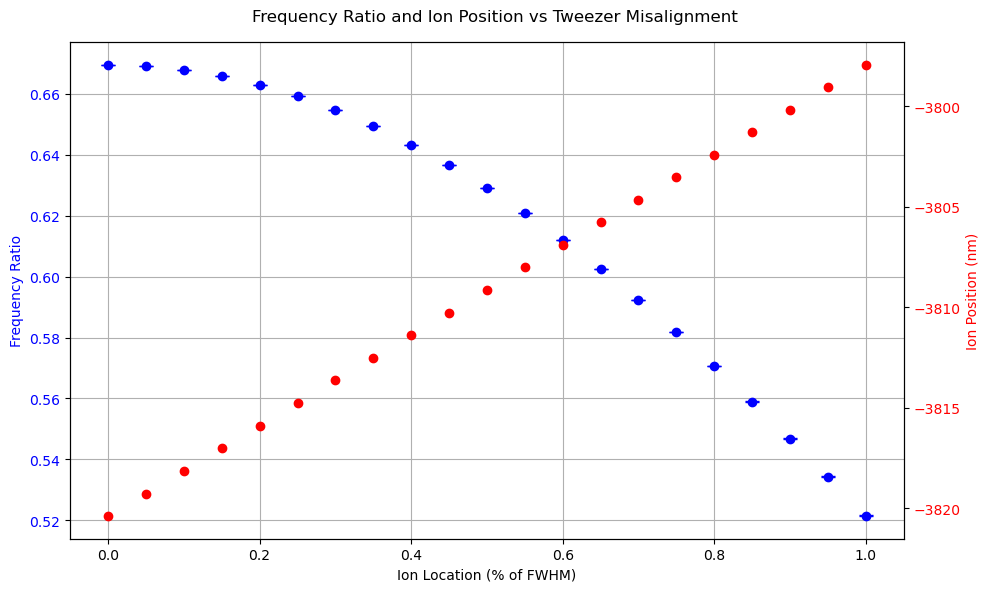

In [147]:
# Dial values for both calculations
dial_values = np.arange(0.0, 1.05, 0.05)
#print(dial_values)
P0_fixed = 50e-3
ratios = []
errors = []
positions3 = []
omega_tw_radial3 = []
beam_waist_fixed = 1e-6

def quadratic(x,a,b):
    return a+b*(x**2)

for dial in dial_values:
    # Intensity and frequency ratio
    if dial == 0:
        r_max = 0.001e-6
        r_min = -0.001e-6
    else:
        r_max = (beam_waist_fixed / 2) * (dial + dial * 0.025)
        r_min = (beam_waist_fixed / 2) * (dial - dial * 0.025)
    r_pos = np.linspace(r_min, r_max, 1000)

    int_vals = intensity(P0_fixed, beam_waist_fixed, 0, r_pos, tweezer_wavelength)
    ydata = potential_position_dependent(omega_res, linewidths, tweezer_wavelength, int_vals)

    xdata = r_pos
    popt, pcov = curve_fit(quadratic, xdata, ydata)
    fit = np.sqrt(2 * popt[1] / m)
    perr = np.sqrt(np.diag(pcov))
    fit_error = np.abs(fit * (perr[1] / popt[1]))

    analytical = tweezer_optical_potential_to_trap_frequency(tweezer_wavelength, linewidths, omega_res, P0_fixed, beam_waist_fixed, m)
    ratio = fit / analytical[0]
    ratio_error = fit_error / analytical[0]

    ratios.append(ratio)
    errors.append(ratio_error)

    # Displacement and ion position
    displacement = beam_waist_fixed * dial
    omega_tw_radial = tweezer_optical_potential_to_trap_frequency(tweezer_wavelength, linewidths, omega_res, P0_fixed, beam_waist_fixed, m)[0]
    tweeze_on = fsolve(pot_derivative_with_tweeze, ionspacing[0], args=(omega_rf_axial, omega_tw_radial, tweezed_ion, displacement))
    positions3.append(tweeze_on[0])
    omega_tw_radial3.append(omega_tw_radial)

positions3 = np.array(positions3) * 1e9  # Convert to nm
freq_tw_radial3 = np.array(omega_tw_radial3) * 1e-6 / (2 * np.pi)  # Convert to MHz

# Unified plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot dial values vs frequency ratio
ax1.errorbar(dial_values, ratios, yerr=errors, fmt='o', label='Fit/Analytical Frequency Ratio', color='blue', capsize=5)
ax1.set_xlabel('Ion Location (% of FWHM)')
ax1.set_ylabel('Frequency Ratio', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Secondary axis for displacement vs ion position
ax2 = ax1.twinx()
ax2.plot(dial_values, positions3, 'o', color='red', label='Ion Position')
ax2.set_ylabel('Ion Position (nm)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add grid, legend, and title
fig.suptitle('Frequency Ratio and Ion Position vs Tweezer Misalignment')
ax1.grid(True)
fig.tight_layout()
plt.savefig("Frequency_Position_Misalignment.png")
plt.show()

In [150]:
# Arrays to store results
ratios = []
errors = []
positions3 = []  # For ion positions
omega_tw_radial3 = []  # For radial frequencies

P0 = 5e-3
FWHM = 1e-6
z_pos = 0
lambda_beam = 532e-9
print(intensity(P0, FWHM, z_pos, r_pos, lambda_beam))
print(potential_position_dependent(omega_res, linewidths, omega_res, intensity(P0, FWHM, z_pos, r_pos, lambda_beam)))

for dial in dial_values:
    # Calculate `r_pos` for frequency calculations
    if dial == 0:
        r_max = 0.001e-5
        r_min = -0.001e-5
    else:
        r_max = (FWHM / 2) * (dial + dial * 0.025)
        r_min = (FWHM / 2) * (dial - dial * 0.025)
    r_pos = np.linspace(r_min, r_max, 100)

    # Frequency ratio calculations (from chunk 2)
    ydata = potential_position_dependent(omega_res, linewidths, omega_res, intensity(P0, FWHM, z_pos, r_pos, lambda_beam))
    xdata = r_pos
    popt, pcov = curve_fit(quadratic, xdata, ydata)

    fit = np.sqrt(2 * popt[1] / m)
    perr = np.sqrt(np.diag(pcov))
    fit_error = np.abs(fit * (perr[1] / popt[1]))

    analytical = tweezer_optical_potential_to_trap_frequency(lambda_beam, linewidths, omega_res, P0, FWHM, m)
    ratio = fit / analytical[0]
    ratio_error = fit_error / analytical[0]

    ratios.append(ratio)
    errors.append(ratio_error)

    # Ion position calculations (from chunk 1)
    displacement = FWHM * dial
    omega_tw_radial = analytical[0]  # Analytical radial frequency
    tweeze_on = fsolve(pot_derivative_with_tweeze, ionspacing[0], args=(omega_rf_axial, omega_tw_radial, tweezed_ion, displacement))
    positions3.append(tweeze_on[0])
    omega_tw_radial3.append(omega_tw_radial)

# Convert to proper units
positions3 = np.array(positions3) * 1e9  # Convert to nm
freq_tw_radial3 = np.array(omega_tw_radial3) * 1e-6 / (2 * np.pi)  # Convert to MHz

# Plot the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot dial values vs frequency ratio
ax1.errorbar(dial_values, ratios, yerr=errors, fmt='o', label='Fit/Analytical Frequency Ratio', color='blue', capsize=5)
ax1.set_xlabel('Ion Location (% of FWHM)')
ax1.set_ylabel('Frequency Ratio', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Secondary axis for displacement vs ion position
ax2 = ax1.twinx()
ax2.plot(dial_values, positions3, 'o', color='red', label='Ion Position')
ax2.set_ylabel('Ion Position (nm)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add grid, legend, and title
fig.suptitle('Frequency Ratio and Ion Position vs Tweezer Misalignment')
ax1.grid(True)
fig.tight_layout()
plt.savefig("Frequency_Position_Misalignment_Combined.png")
plt.show()

[1.97890311e+09 1.97880654e+09 1.97870997e+09 1.97861341e+09
 1.97851684e+09 1.97842027e+09 1.97832370e+09 1.97822713e+09
 1.97813056e+09 1.97803399e+09 1.97793742e+09 1.97784085e+09
 1.97774428e+09 1.97764771e+09 1.97755113e+09 1.97745456e+09
 1.97735799e+09 1.97726142e+09 1.97716485e+09 1.97706827e+09
 1.97697170e+09 1.97687513e+09 1.97677856e+09 1.97668198e+09
 1.97658541e+09 1.97648883e+09 1.97639226e+09 1.97629569e+09
 1.97619911e+09 1.97610254e+09 1.97600596e+09 1.97590939e+09
 1.97581281e+09 1.97571623e+09 1.97561966e+09 1.97552308e+09
 1.97542651e+09 1.97532993e+09 1.97523335e+09 1.97513677e+09
 1.97504020e+09 1.97494362e+09 1.97484704e+09 1.97475046e+09
 1.97465389e+09 1.97455731e+09 1.97446073e+09 1.97436415e+09
 1.97426757e+09 1.97417099e+09 1.97407441e+09 1.97397783e+09
 1.97388125e+09 1.97378467e+09 1.97368809e+09 1.97359151e+09
 1.97349493e+09 1.97339835e+09 1.97330177e+09 1.97320518e+09
 1.97310860e+09 1.97301202e+09 1.97291544e+09 1.97281886e+09
 1.97272227e+09 1.972625

/Users/ritika/SQRL_Rithi_python/BladeRunner/Tweezers/tweezer_functions.py:151: RuntimeWarning: divide by zero encountered in divide
  * (linewidths[i]/((omega_res[i] - omega_tweezer)) +


ValueError: operands could not be broadcast together with shapes (2,) (1000,) 

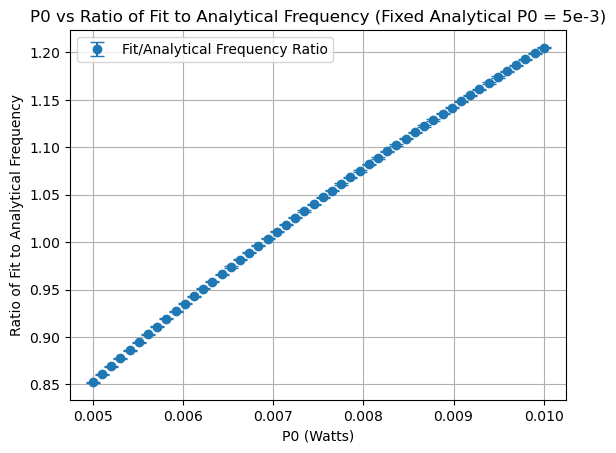

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# Assuming required functions and variables like 'potential_position_dependent', 'quadratic', 'm', etc., are defined elsewhere

# Define the range for the P0 values (adjust the range and step size as needed)
P0_values = np.linspace(5e-3, 10e-3, 50)  # P0 values ranging from 5 mW to 10 mW
P0_values_miliwatts = P0_values * 1000  # Convert to miliwatts for plotting

# Fixed dial value
dial = 0.8

# Fixed P0 for analytical frequency calculation
P0_analytical = 5e-3

# List to store the results
results = []
ratios = []
errors = []  # To store the errors for the ratio

# Define a fixed number of points for r_pos
num_points = 50  # Fixed number of points for each P0 value

# Calculate the analytical frequency only once using P0_analytical
analytical = tweezer_optical_potential_to_trap_frequency(lambda_beam, linewidths, omega_res, P0_analytical, FWHM, m)

for P0 in P0_values:
    r_max = (FWHM / 2) * (dial + dial * 0.025) 
    r_min = (FWHM / 2) * (dial - dial * 0.025) 
    r_pos = np.linspace(r_min, r_max, num_points)

    # Recalculate ydata for each P0 value
    ydata = potential_position_dependent(omega_res, linewidths, omega_tweezer, intensity(P0, FWHM, z_pos, r_pos, lambda_beam))

    # Use r_pos and ydata for fitting
    xdata = r_pos

    # Perform the fit for the potential
    popt, pcov = optimize.curve_fit(quadratic, xdata, ydata)

    # Calculate the fit-based radial frequency
    fit = np.sqrt(2 * popt[1] / m)

    # Estimate error from the covariance matrix for popt[1]
    perr = np.sqrt(np.diag(pcov))
    fit_error = np.abs(fit * (perr[1] / popt[1]))

    # Calculate the ratio of fit to analytical frequency and collect data for plotting
    ratio = fit / analytical[0]
    ratio_error = fit_error / analytical[0]

    results.append((dial, ratio))
    ratios.append(ratio)  # Collect ratios for plotting
    errors.append(ratio_error)  # Collect errors for error bars

# Plot the P0 values against the ratios
fig, ax = plt.subplots()
#ax.figure(figsize=(8, 6))
ax.errorbar(P0_values, ratios, yerr=errors, fmt='o', label='Fit/Analytical Frequency Ratio', capsize=5)
ax.set_xlabel('P0 (Watts)')
ax.set_ylabel('Ratio of Fit to Analytical Frequency')
ax.set_title('P0 vs Ratio of Fit to Analytical Frequency (Fixed Analytical P0 = 5e-3)')
ax.legend()
ax.grid(True)
#ax.set_xticks(P0_values,labels = P0_values_miliwatts)
plt.savefig("Trapping_Frequency_P0.png")
plt.show()

# Optionally print a specific P0 and ratio
#print(f"P0: {P0_values[7]:.5f}, Ratio: {ratios[7]:.5f}")
